In [1]:
import json
import pandas as pd
import re
import nltk
import tensorflow as tf
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Load dataset
file_path = './Data/all_data_resep.csv'
data = pd.read_csv(file_path)

# Gabungkan kolom-kolom yang relevan 
data['Combined_Text'] = data['Title'] + " " + data['Ingredients'] + " " + data['Steps']

# Tambahkan threshold untuk kolom 'Loves'
threshold = 50
data['Label'] = (data['Loves'] >= threshold).astype(int)

In [2]:
# Bersihkan teks
nltk.download('wordnet')
nltk.download('stopwords')

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def replace_hyphens(text):
    return text.replace('--', ',')

def clean_text(text):
    text = text.lower()
    # text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = stopword.remove(text)
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# data['Ingredients'] = data['Ingredients'].fillna('').apply(clean_text)
data['Ingredients'] = data['Ingredients'].fillna('').apply(replace_hyphens)
data['Steps'] = data['Steps'].fillna('').apply(replace_hyphens)
data['Cleaned_Text'] = data['Combined_Text'].apply(clean_text)

[nltk_data] Downloading package wordnet to C:\Users\Santi
[nltk_data]     Susanti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Santi
[nltk_data]     Susanti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Menghapus emoji 
def clean_emoji(text):
  if text is not None and isinstance(text, str):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['Title'] = data['Title'].apply(clean_emoji)
data['Ingredients'] = data['Ingredients'].apply(clean_emoji)
data['Steps'] = data['Steps'].apply(clean_emoji)
data['Combined_Text'] = data['Combined_Text'].apply(clean_emoji)
data.head(1)

,Title,Ingredients,Steps,Loves,URL,Combined_Text,Label,Cleaned_Text
0,Ayam Woku Manado,"1 Ekor Ayam Kampung (potong 12),2 Buah Jeruk N...",Cuci bersih ayam dan tiriskan. Lalu peras jeru...,1,/id/resep/4473027-ayam-woku-manado,Ayam Woku Manado 1 Ekor Ayam Kampung (potong 1...,0,ayam woku manado 1 ekor ayam kampung (potong 1...


In [4]:
# Tokenisasi data teks yang sudah dibersihkan
data['Tokenized_Text'] = data['Cleaned_Text'].apply(lambda x: x.split())

word2vec_model = Word2Vec(
    sentences=data['Tokenized_Text'], 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4, 
    sg=1
)

# Simpan model untuk digunakan kembali
# word2vec_model.save("word2vec_resep.model")

In [5]:
# Fungsi untuk menghitung rata-rata embedding sebuah dokumen
def document_embedding(text, model, vector_size=100):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

data['Embedding'] = data['Cleaned_Text'].apply(
    lambda x: document_embedding(x, word2vec_model, vector_size=100)
)


In [6]:
data.head()

,Title,Ingredients,Steps,Loves,URL,Combined_Text,Label,Cleaned_Text,Tokenized_Text,Embedding
0,Ayam Woku Manado,"1 Ekor Ayam Kampung (potong 12),2 Buah Jeruk N...",Cuci bersih ayam dan tiriskan. Lalu peras jeru...,1,/id/resep/4473027-ayam-woku-manado,Ayam Woku Manado 1 Ekor Ayam Kampung (potong 1...,0,ayam woku manado 1 ekor ayam kampung (potong 1...,"[ayam, woku, manado, 1, ekor, ayam, kampung, (...","[-0.023722041, 0.59770894, 0.16852401, -0.1150..."
1,Ayam goreng tulang lunak,1 kg ayam (dipotong sesuai selera jangan kecil...,"Haluskan bumbu2nya (BaPut, ketumbar, kemiri, k...",1,/id/resep/4471956-ayam-goreng-tulang-lunak,Ayam goreng tulang lunak 1 kg ayam (dipotong s...,0,ayam goreng tulang lunak 1 kg ayam (dipotong s...,"[ayam, goreng, tulang, lunak, 1, kg, ayam, (di...","[-0.15513903, 0.5601635, 0.106817074, -0.17861..."
2,Ayam cabai kawin,"1/4 kg ayam,3 buah cabai hijau besar,7 buah ca...",Panaskan minyak di dalam wajan. Setelah minyak...,2,/id/resep/4473057-ayam-cabai-kawin,Ayam cabai kawin 1/4 kg ayam--3 buah cabai hij...,0,ayam cabai kawin 1/4 kg ayam--3 buah cabai hij...,"[ayam, cabai, kawin, 1/4, kg, ayam--3, buah, c...","[-0.11829103, 0.65531814, 0.09266335, -0.12293..."
3,Ayam Geprek,"250 gr daging ayam (saya pakai fillet),Secukup...","Goreng ayam seperti ayam krispi,Ulek semua bah...",10,/id/resep/4473023-ayam-geprek,Ayam Geprek 250 gr daging ayam (saya pakai fil...,0,ayam geprek 250 gr daging ayam (saya pakai fil...,"[ayam, geprek, 250, gr, daging, ayam, (saya, p...","[-0.19516218, 0.3897892, 0.07253408, -0.171631..."
4,Minyak Ayam,"400 gr kulit ayam & lemaknya,8 siung bawang pu...","Cuci bersih kulit ayam. Sisihkan,Ambil 50 ml m...",4,/id/resep/4427438-minyak-ayam,Minyak Ayam 400 gr kulit ayam & lemaknya--8 si...,0,minyak ayam 400 gr kulit ayam & lemaknya--8 si...,"[minyak, ayam, 400, gr, kulit, ayam, &, lemakn...","[-0.14296913, 0.48159727, 0.05704384, -0.20455..."


In [7]:
X = np.array(data['Embedding'].tolist())  
y = data['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi ke TensorFlow Tensor
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.int32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.int32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_val_tensor = tf.convert_to_tensor(y_val.values, dtype=tf.int32)


In [8]:
def create_embedding_model(input_shape):
    model = models.Sequential()
    
    # Layer pertama (Dense dengan L2 Regularization dan Dropout)
    model.add(layers.Dense(128, activation='relu', input_shape=input_shape,
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    # Layer kedua
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    # Layer ketiga
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    # Layer output
    model.add(layers.Dense(1, activation='sigmoid'))  # Untuk klasifikasi biner
    
    # Kompilasi model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Input shape harus sesuai dengan ukuran embedding (contoh: 100)
embedding_model = create_embedding_model((X_train_tensor.shape[1],))
embedding_model.summary()

C:\Users\Santi Susanti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

history = embedding_model.fit(
    X_train_tensor, 
    y_train_tensor,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_tensor, y_val_tensor),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9585 - loss: 1.5059 - val_accuracy: 0.9615 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9631 - loss: 0.5082 - val_accuracy: 0.9615 - val_loss: 0.4292 - learning_rate: 0.0010
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9595 - loss: 0.4096 - val_accuracy: 0.9615 - val_loss: 0.3516 - learning_rate: 0.0010
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9620 - loss: 0.3362 - val_accuracy: 0.9615 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9608 - loss: 0.2872 - val_accuracy: 0.9615 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9609 - loss: 0.2513 - val_accuracy: 0.9615 - val_loss: 0.2300 - learning_rate: 0.0010
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9615 - loss: 0.2246 - 

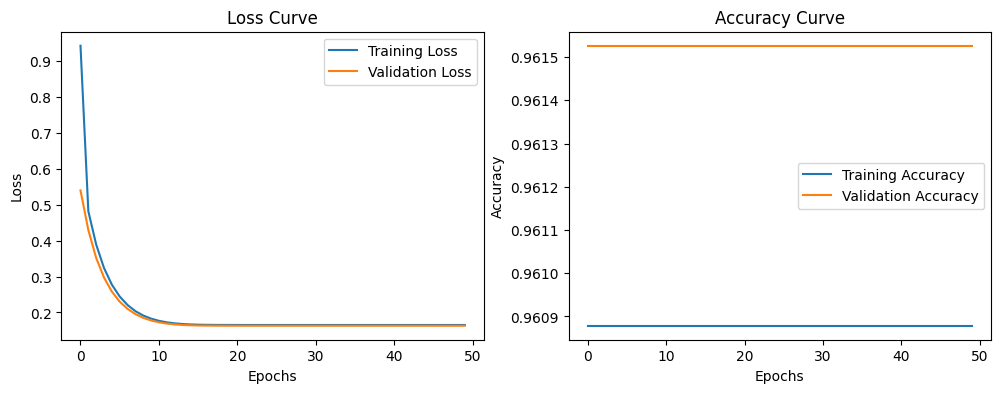

In [10]:
# Menampilkan hasil pelatihan
import matplotlib.pyplot as plt

# Ploting loss dan accuracy
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# # Evaluasi model pada data validasi
# val_loss, val_accuracy = model.evaluate(X_val_tensor, y_val_tensor)
# print(f'Validation Loss: {val_loss}')
# print(f'Validation Accuracy: {val_accuracy}')

In [11]:
def recommend_recipes_with_embedding_sorted(query, word2vec_model, data, top_n=10, vector_size=100):
    """
    Memberikan rekomendasi berdasarkan query menggunakan cosine similarity dari Word2Vec embedding,
    dan mengurutkan berdasarkan jumlah Loves secara descending.
    
    Parameters:
        query (str): Input teks query (misal: "ayam bakar").
        word2vec_model: Model Word2Vec yang digunakan untuk embedding.
        data (DataFrame): Dataframe yang berisi kolom 'Embedding' dan 'Cleaned_Text'.
        top_n (int): Jumlah rekomendasi yang diinginkan.
        vector_size (int): Dimensi embedding Word2Vec.
    
    Returns:
        List[Dict]: Rekomendasi dalam format list of dictionaries.
    """
    # Preprocess query
    query_cleaned = clean_text(query)
    
    # Generate embedding untuk query
    query_embedding = document_embedding(query_cleaned, word2vec_model, vector_size=vector_size)
    
    # Hitung cosine similarity antara query dan semua embedding dalam dataset
    doc_embeddings = np.array(data['Embedding'].tolist())
    similarities = cosine_similarity([query_embedding], doc_embeddings)[0]
    
    # Ambil top N rekomendasi berdasarkan similarity
    top_indices = similarities.argsort()[-top_n:][::-1] 
    recommended_recipes = data.iloc[top_indices]
    
    # Urutkan berdasarkan 'Loves' secara descending
    recommended_recipes = recommended_recipes.sort_values(by=['Loves'], ascending=False)
    
    # Convert hasil ke JSON format serializable
    recommendations_json = recommended_recipes[['Title', 'Ingredients', 'Steps', 'Loves']].to_dict(orient='records')
    
    return recommendations_json
    

In [13]:
query = "udang rebus"
recommended_recipes_json = recommend_recipes_with_embedding_sorted(query, word2vec_model, data, top_n=10)

# Simpan hasil dalam format JSON
with open('recommended_recipes_embedding.json', 'w', encoding='utf-8') as json_file:
    json.dump(recommended_recipes_json, json_file, ensure_ascii=False, indent=4)

# Tampilkan hasil
print(json.dumps(recommended_recipes_json, ensure_ascii=False, indent=4))


[
    {
        "Title": "Udang goreng simple",
        "Ingredients": "1/2 kg udang segar,3 siung bawang putih,2 mata asam jawa,secukupnya Garam,",
        "Steps": "Cuci bersih udang dan buang kepalanya, sisihkan,Haluskan bawang putih, garam, dan asam jawa,Balurkan bumbu ke udang, diamkan 30 menit, lalu goreng,Sisa udang yg telah berbumbu bisa disimpan di kulkas, dan goreng sesaat sebelum makan,",
        "Loves": 18
    },
    {
        "Title": "Tumis bawang rambut udang pape",
        "Ingredients": "1 ikat bawang rambut,20 gram udang pape,4 buah cabe,Garam dan kaldu,",
        "Steps": "Rendam sebentar udang dan cuci bersih. Potong daun bawang dan cabe,Tumis semua bahan hingga harum tambah kan sedikit air berikan garam dan kaldu. Masak hingga air berkurang.,",
        "Loves": 12
    },
    {
        "Title": "Sup Iga Sapi",
        "Ingredients": "500 gr tulang iga sapi,2 buah wortel,1 buah kurma kering,4 buah jamur kering, rendam lalu iris panjang,secukupnya Daun seledri,secuku

In [14]:
# Save Model ke h5
model.save('feat-search-2.h5')

NameError: name 'model' is not defined

In [ ]:
# # Convert to tensorflowjs
# tensorflowjs_converter --input_format keras model_recipes.h5 tfjs_model/

In [ ]:
# from flask import Flask, request, jsonify

# app = Flask(__name__)

# # Endpoint untuk mendapatkan rekomendasi
# @app.route('/recommend', methods=['POST'])
# def recommend():
#     query = request.json.get('query', '')
#     top_n = int(request.json.get('top_n', 5))
#     recommendations = recommend_recipes(query, data, word2vec_model, top_n)
#     response = recommendations[['Title', 'Ingredients', 'Steps', 'Loves']].to_dict(orient='records')
#     return jsonify(response)

# if __name__ == '__main__':
#     app.run(debug=True)
